# 0.0 Imports

In [27]:
import random
import datetime
import multiprocessing
import pandas_profiling

import pandas   as pd
import numpy    as np
import seaborn  as sns

from keras      import models          as ml
from keras      import layers          as l
from sklearn    import model_selection as ms
from sklearn    import preprocessing   as pp
from sklearn    import metrics         as m
from scikitplot import metrics         as mt
from scipy      import stats           as ss
from datetime   import datetime        as dt

from imblearn.combine        import SMOTETomek

from pandas_profiling        import ProfileReport
from imblearn.pipeline       import Pipeline

from sklearn.datasets        import make_classification
from sklearn.model_selection import cross_validate
from sklearn.model_selection import RepeatedStratifiedKFold
from category_encoders       import TargetEncoder
from IPython.core.display    import HTML

## 0.1 Helper Funtions

In [28]:
def jupyter_settings():
    %matplotlib inline
    %pylab inline

    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [18, 10]
    plt.rcParams['font.size'] = 24
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    sns.set()
    
def cramer_v (x,y):

    cm = pd.crosstab(x, y).values
    n = cm.sum()
    r,k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max(0, chi2 - (k-1)*(r-1)/(n-1))
    
    kcorr = k - (k -1)**2/(n-1)
    rcorr = r - (r -1)**2/(n-1)
    
    return np.sqrt((chi2corr/n)/(min(kcorr-1, rcorr-1)))

In [29]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\IPython\core\magics\pylab.py:159: UserWarning: pylab import has clobbered these variables: ['random']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


## 0.2 Loanding Data

In [30]:
df_raw = pd.read_csv ('training_users.csv', low_memory = True)
df_raw.shape

(213451, 16)

In [31]:
df_sessions = pd.read_csv ('sessions.csv', low_memory = True)
df_sessions.shape

(10567737, 6)

# 1.0 Data Description

In [32]:
df1 = df_raw.copy()

## 1.1 Data Dimensions

In [33]:
print('Number of Rows: {}.'.format(df1.shape[0]))
print('Number of Columns: {}.'.format(df1.shape[1]))

Number of Rows: 213451.
Number of Columns: 16.


In [34]:
print('Number of Rows: {}.'.format(df_sessions.shape[0]))
print('Number of Columns: {}.'.format(df_sessions.shape[1]))

Number of Rows: 10567737.
Number of Columns: 6.


## 1.2 Date Type

In [35]:
df1.dtypes

id                          object
date_account_created        object
timestamp_first_active       int64
date_first_booking          object
gender                      object
age                        float64
signup_method               object
signup_flow                  int64
language                    object
affiliate_channel           object
affiliate_provider          object
first_affiliate_tracked     object
signup_app                  object
first_device_type           object
first_browser               object
country_destination         object
dtype: object

In [36]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

## 1.3 NA Check

In [37]:
df1.isna().sum() / len (df1)

id                         0.000000
date_account_created       0.000000
timestamp_first_active     0.000000
date_first_booking         0.583473
gender                     0.000000
age                        0.412226
signup_method              0.000000
signup_flow                0.000000
language                   0.000000
affiliate_channel          0.000000
affiliate_provider         0.000000
first_affiliate_tracked    0.028414
signup_app                 0.000000
first_device_type          0.000000
first_browser              0.000000
country_destination        0.000000
dtype: float64

In [38]:
df_sessions.isna().sum() / len (df_sessions)

user_id          0.003264
action           0.007535
action_type      0.106570
action_detail    0.106570
device_type      0.000000
secs_elapsed     0.012872
dtype: float64

## 1.4 Fill NA

In [39]:
## Remove Missing Values (df1)

# date_first_booking

# porcentagem das classes

aux = df1[df1['date_first_booking'].isna()]
aux['country_destination'].value_counts(normalize = True) 

date_first_booking_max = pd.to_datetime (df1['date_first_booking']).max().strftime( '%Y%m%d' )
df1['date_first_booking'] = df1['date_first_booking'].fillna (date_first_booking_max)

In [40]:
# age

# porcentagem das classes

aux = df1[df1['age'].isna()]
aux['country_destination'].value_counts(normalize = True) 

df1 = df1[(df1['age'] > 15) & (df1['age'] < 120)]
avg_age = int(df1['age'].mean())
df1['age'] = df1['age'].fillna(avg_age)

In [41]:
# first_affiliate_tracked  

df1 = df1[~df1['first_affiliate_tracked'].isna()]

In [42]:
## Remove Missing Values (df_sessions)

#user_id 
df_sessions = df_sessions[~df_sessions['user_id'].isna()]

#action
df_sessions = df_sessions[~df_sessions['action'].isna()]

#action_type
df_sessions = df_sessions[~df_sessions['action_type'].isna()]

#action_detail
df_sessions = df_sessions[~df_sessions['action_detail'].isna()]

#device_type
df_sessions = df_sessions[~df_sessions['device_type'].isna()]

#secs_elapsed    
df_sessions = df_sessions[~df_sessions['secs_elapsed'].isna()]

## 1.5 Change Data Type

In [43]:
# date_account_created
df1['date_account_created'] = pd.to_datetime (df1['date_account_created'])

# timestamp_first_active
df1['timestamp_first_active'] = pd.to_datetime (df1['timestamp_first_active'], format = '%Y%m%d%H%M%S')

#date_first_booking
df1['date_first_booking'] = pd.to_datetime (df1['date_first_booking'])

# age
df1['age'] = df1['age'].astype('int64')

## 1.6 Check Balanced Data


In [44]:
df1['country_destination'].value_counts(normalize = True) #percent

NDF      0.447275
US       0.391867
other    0.061246
FR       0.029918
IT       0.016423
GB       0.014335
ES       0.013740
CA       0.008676
DE       0.006858
NL       0.004852
AU       0.003531
PT       0.001280
Name: country_destination, dtype: float64

## 1.7 Descriptive Analysis

In [45]:
#users

num_attributes = df1.select_dtypes(include = ['int64', 'float64'])
cat_attributes = df1.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
time_attributes = df1.select_dtypes(include = ['datetime64[ns]'])

#sessions

num_attributes_sessions = df_sessions.select_dtypes(include = ['int64', 'float64'])
cat_attributes_sessions = df_sessions.select_dtypes(exclude = ['int64', 'float64', 'datetime64[ns]'])
time_attributes_sessions = df_sessions.select_dtypes(include = ['datetime64[ns]'])

### 1.7.1 Numerical -  Users

In [46]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame (num_attributes.apply (np.mean)).T
ct2 = pd.DataFrame (num_attributes.apply (np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame (num_attributes.apply (np.std)).T
d2 = pd.DataFrame (num_attributes.apply (min)).T
d3 = pd.DataFrame (num_attributes.apply (max)).T
d4 = pd.DataFrame (num_attributes.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes.apply (lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes.apply (lambda x: x.kurtosis())).T

# Concatenate

t = pd.concat ((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()
t.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

t

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,age,16.0,115.0,99.0,37.405591,34.0,13.939844,2.089718,6.516468
1,signup_flow,0.0,25.0,25.0,2.519513,0.0,6.604696,2.705871,5.928298


### 1.7.2 Numerical - Sessions

In [47]:
# Central Tendency - Mean, Median
ct1 = pd.DataFrame (num_attributes_sessions.apply (np.mean)).T
ct2 = pd.DataFrame (num_attributes_sessions.apply (np.median)).T

#Dispersion - std, min, max, range, skew, kurtosis

d1 = pd.DataFrame (num_attributes_sessions.apply (np.std)).T
d2 = pd.DataFrame (num_attributes_sessions.apply (min)).T
d3 = pd.DataFrame (num_attributes_sessions.apply (max)).T
d4 = pd.DataFrame (num_attributes_sessions.apply (lambda x: x.max() - x.min())).T
d5 = pd.DataFrame (num_attributes_sessions.apply (lambda x: x.skew())).T
d6 = pd.DataFrame (num_attributes_sessions.apply (lambda x: x.kurtosis())).T

# Concatenate

t = pd.concat ((d2, d3, d4, ct1, ct2, d1, d5, d6)).T.reset_index()
t.columns =['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']

t

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,secs_elapsed,0.0,1799977.0,1799977.0,19961.8251,1369.0,88849.388449,11.137761,154.84312


### 1.7.3 Categorical -  Users

In [48]:
cat_attributes.drop('id', axis = 1).describe()

,gender,signup_method,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
count,122636,122636,122636,122636,122636,122636,122636,122636,122636,122636
unique,4,3,25,8,17,7,4,9,41,12
top,FEMALE,basic,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
freq,56362,66039,118205,79093,78954,64712,108283,57943,41778,54852


### 1.7.4 Categorical -  Sessions

In [49]:
cat_attributes_sessions.drop('user_id', axis = 1).describe()

,action,action_type,action_detail,device_type
count,9213930,9213930,9213930,9213930
unique,347,10,155,14
top,show,view,view_search_results,Mac Desktop
freq,2178382,3545621,1770931,3019523


In [50]:
#list of attributes for Cramer's V correlation

cat_attributes_list = cat_attributes_sessions.drop('user_id', axis = 1).columns.tolist()

corr_dict = {}

for i in range (len (cat_attributes_list)):
    corr_list = []
    for j in range (len (cat_attributes_list)):
        ref = cat_attributes_list[i]
        feat = cat_attributes_list[j]
        
        #correlation
        corr = cramer_v(cat_attributes_sessions[ref], cat_attributes_sessions[feat])
        
        #append a list
        corr_list.append (corr)
    
    #append a correlation list for each ref attributes
    corr_dict[ref] = corr_list

<AxesSubplot:>

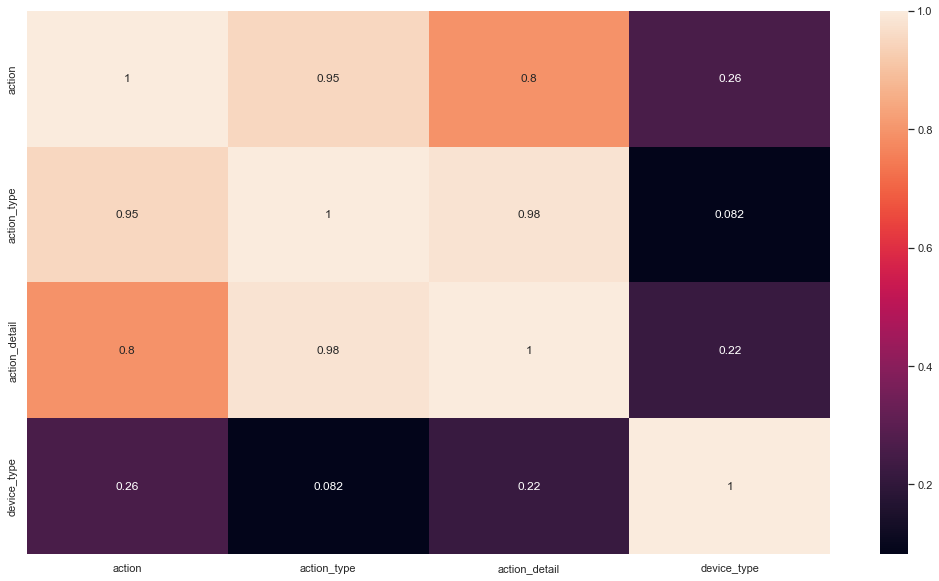

In [51]:
d = pd.DataFrame (corr_dict)
d = d.set_index (d.columns)

sns.heatmap (d, annot = True)

# 2.0 Feature Engineering

In [52]:
df2 = df1. copy()

In [53]:
df2.dtypes

id                                 object
date_account_created       datetime64[ns]
timestamp_first_active     datetime64[ns]
date_first_booking         datetime64[ns]
gender                             object
age                                 int64
signup_method                      object
signup_flow                         int64
language                           object
affiliate_channel                  object
affiliate_provider                 object
first_affiliate_tracked            object
signup_app                         object
first_device_type                  object
first_browser                      object
country_destination                object
dtype: object

## 2.1 Create New Features

In [54]:
#days from first active up to first booking
df2['first_active'] = pd.to_datetime (df2['timestamp_first_active'].dt.strftime ('%Y%m%d'))
df2['days_from_first_active_until_booking'] = (df2['date_first_booking']  - df2['first_active']).apply (lambda x: x.days)

#days from first active up to account created
df2['days_from_first_active_account_created'] = (df2['date_account_created']  - df2['first_active']).apply (lambda x: x.days)

#days from account created up to first booking
df2['days_from_account_created_first_booking'] = (df2['date_first_booking']  - df2['date_account_created']).apply (lambda x: x.days)


#year of first active
df2['year_first_active'] = df2['first_active'].dt.year

#month of first active
df2['month_first_active'] = df2['first_active'].dt.month

#day of first active
df2['day_first_active'] = df2['first_active'].dt.day

#day of week active
df2['day_of_week_first_active'] = df2['first_active'].dt.dayofweek

#week of first active
df2['week_first_active'] = df2['first_active'].dt.isocalendar().week



#year of first booking
df2['year_first_booking'] = df2['date_first_booking'].dt.year

#month of first booking
df2['month_first_booking'] = df2['date_first_booking'].dt.month

#day of first booking
df2['day_first_booking'] = df2['date_first_booking'].dt.day

#day of week booking
df2['day_of_week_first_booking'] = df2['date_first_booking'].dt.dayofweek

#week of first booking
df2['week_first_booking'] = df2['date_first_booking'].dt.isocalendar().week


#year of first created
df2['year_first_account_created'] = df2['date_account_created'].dt.year

#month of first created
df2['month_first_account_created'] = df2['date_account_created'].dt.month

#day of first created
df2['day_first_account_created'] = df2['date_account_created'].dt.day

#day of week created
df2['day_of_week_account_created'] = df2['date_account_created'].dt.dayofweek

#week of first created
df2['week_first_account_created'] = df2['date_account_created'].dt.isocalendar().week

In [55]:
df_sessions.dtypes

user_id           object
action            object
action_type       object
action_detail     object
device_type       object
secs_elapsed     float64
dtype: object

# 3.0 Data Filtering

In [56]:
df3 = df2.copy()

### 3.1 Filtering Rows

In [57]:
#age

df3 = df3[(df3['age'] > 15) & (df3['age'] < 120)]

#secs_elapsed

#df_sessions = df_sessions[df_sessions['secs_elapsed'] > 0]

### 3.2 Columns Selection

In [58]:
#cols = ['date_account_created', 'date_first_booking', 'first_active', 'timestamp_first_active']
#df3 = df3.drop (cols, axis = 1)

# 4.0 Balanced Dataset

In [59]:
df4 =  df3.copy()

In [60]:
#Enconder Categorical Variables
ohe = pp.OneHotEncoder()

#Numerical
col_num = df4.select_dtypes ( include = ['int64', 'float64']).columns.tolist()

#Categorical
col_cat = df4.select_dtypes ( exclude = ['int64', 'float64', 'datetime64[ns]']).drop (['id', 'country_destination'], axis = 1).columns.tolist()

#Encoding
df4_dummy = pd.DataFrame (ohe.fit_transform (df4[col_cat]).toarray(), index = df4.index )

#Join Numerical + Categorical
df4_1 = pd.concat ([df4[col_num], df4_dummy], axis = 1)

### SMOTE + TOMEKLINK

In [61]:
# Definir o sampler

smt = SMOTETomek(random_state=32)

# Fit - Training Data

X_smt, y_smt = smt.fit_resample (df4_1, df4['country_destination'])

C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\sklearn\utils\validation.py:1675: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  warnings.warn(


In [72]:
#numerical data
df4_2 = X_smt [col_num]

#categorical data
df4_3 = X_smt.drop (col_num, axis = 1)
df4_4 = pd.DataFrame(ohe.inverse_transform (df4_3), columns = col_cat, index = df4_3.index)

#join num + cat
df4_5 = pd.concat ([df4_2, df4_4], axis = 1)
df4_5['country_destination'] = y_smt

In [73]:
df4_2 = df4_2.to_csv('df4_2')

In [74]:
df4_3 = df4_3.to_csv('df4_3')

In [75]:
df4_4 = df4_4.to_csv('df4_4')

In [76]:
df4_5 = df4_5.to_csv('df4_5')

# 5.0 Exploratory Data Analysis (EDA)

## 5.1 Univariate Analysis - Feature Behaviour (Balanced Dataset)

In [77]:
df5_1 = df4_5.copy()

AttributeError: 'NoneType' object has no attribute 'copy'

In [78]:
def test_profile():

    proof = pandas_profiling.ProfileReport(df5_1)
    proof.to_file("output.html")

if __name__ == '__main__':
    multiprocessing.freeze_support()
    test_profile()

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

C:\Users\marin\.conda\envs\Projeto01\lib\site-packages\scipy\stats\stats.py:4812: RuntimeWarning: overflow encountered in longlong_scalars
  (2 * xtie * ytie) / m + x0 * y0 / (9 * m * (size - 2)))


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

## 5.2 Bivariate Analysis - Hypothesys Validation (Unbalanced Dataset)

### H1. Em todos os destinos, os usuários levam 15 dias, em média, para fazer a primeira reserva no Airbnb, desde sua primeira ativação.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_until_booking'>

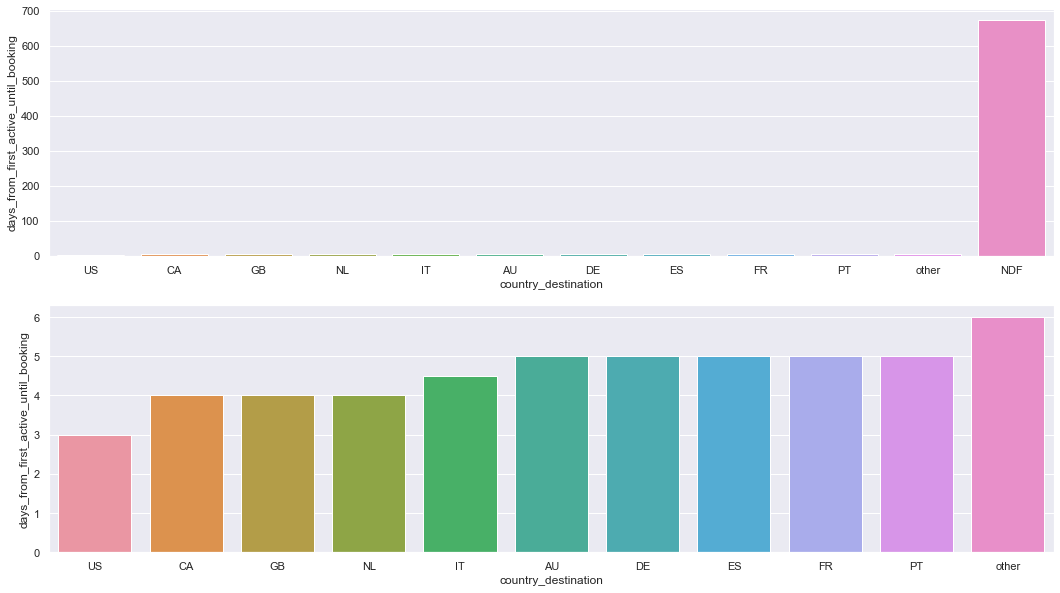

In [65]:
plt.subplot (2,1,1)
aux01 = df4[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot (x = 'country_destination', y = 'days_from_first_active_until_booking', data = aux01.sort_values('days_from_first_active_until_booking'))


plt.subplot (2,1,2)
aux02 = df4[df4['country_destination'] != 'NDF']
aux02 = aux02[['days_from_first_active_until_booking', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot (x = 'country_destination', y = 'days_from_first_active_until_booking', data = aux02.sort_values ('days_from_first_active_until_booking'))


#plt.subplot (3,1,3)
#aux03 = df4[(df4['days_from_first_active_until_booking'] < 50) & (df4['country_destination'] == 'US')]['days_from_first_active_until_booking']
#sns.distplot (aux03)

### H2. Em todos os destinos, os usuários levam 3 dias, em média, para fazer o cadastro no site.

<AxesSubplot:xlabel='country_destination', ylabel='days_from_first_active_account_created'>

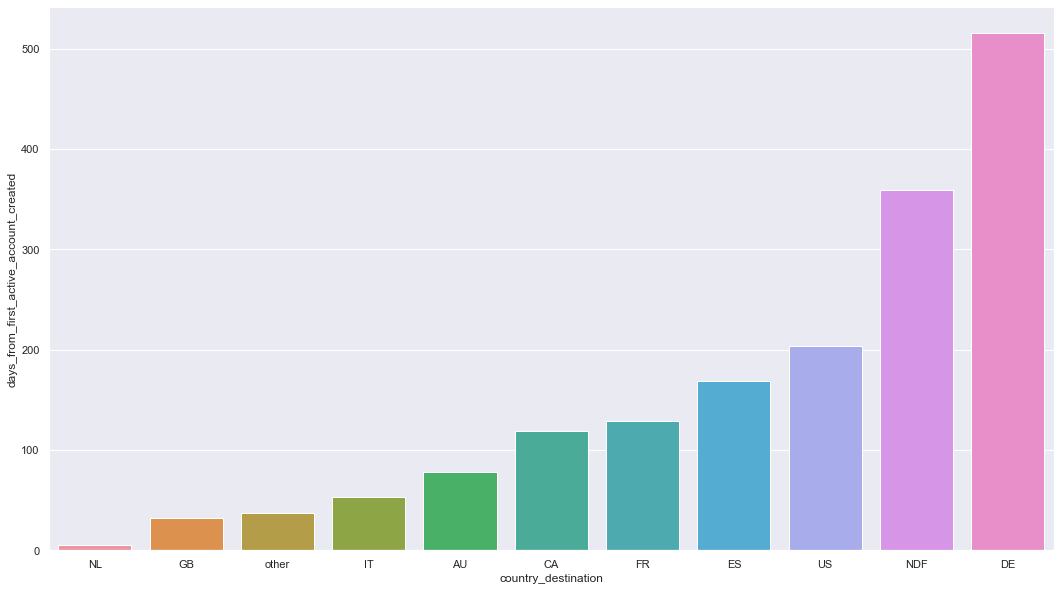

In [66]:
aux02 = df4[df4['days_from_first_active_account_created'] != 0]
aux02 = aux02[['days_from_first_active_account_created', 'country_destination']].groupby('country_destination').median().reset_index()
sns.barplot (x = 'country_destination', y = 'days_from_first_active_account_created', data = aux02.sort_values ('days_from_first_active_account_created'))

In [67]:
df4.loc[df4['days_from_first_active_account_created'] == 0, 'days_from_first_active_account_created'].value_counts()

0    122482
Name: days_from_first_active_account_created, dtype: int64

### H3. O volume de reservas anual feitas durante o verão aumentaram 20% para destinos dentro dos USA.

<AxesSubplot:xlabel='year_first_booking', ylabel='delta'>

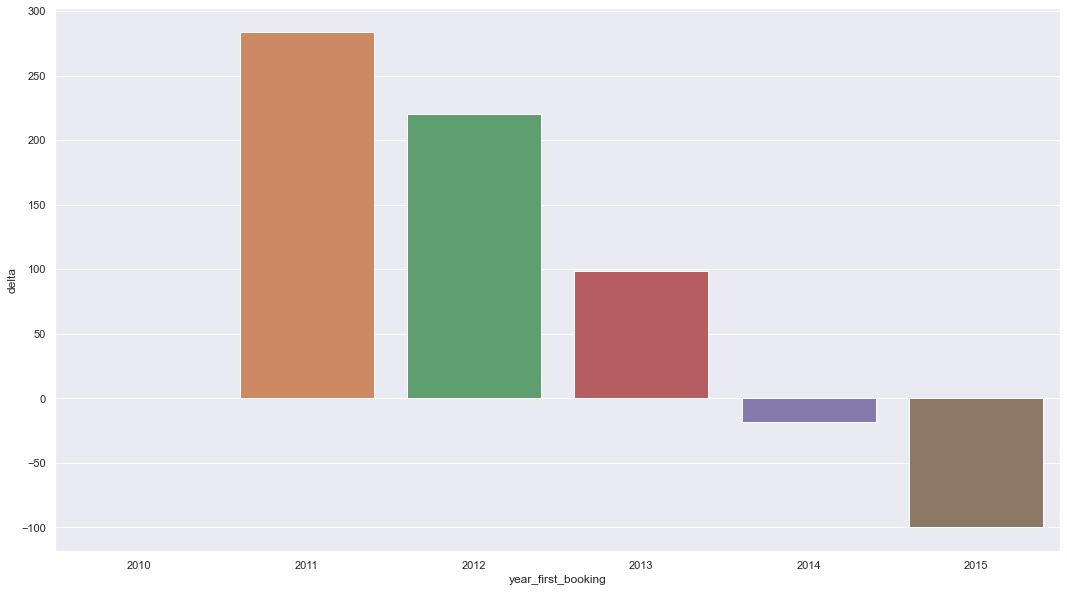

In [68]:
aux01 = df4[['year_first_booking', 'month_first_booking', 'country_destination']].\
groupby(['year_first_booking','month_first_booking','country_destination']).size().reset_index().rename (columns = {0:'count'})

#Only Summer
aux01 = aux01[(aux01['month_first_booking'].isin([6, 7, 8, 9])) & (aux01['country_destination'] == 'US')]

aux02 = aux01[['year_first_booking', 'count']].groupby ('year_first_booking').sum().reset_index()

#diferença entre colunas
aux02['delta'] = 100*aux02['count'].pct_change().fillna(0)

sns.barplot (x = 'year_first_booking', y = 'delta', data = aux02)

### H4. Usuários do sexo feminino fazem 10% mais reservas para países foram dos USA.

### H5. O canal de Marketing Google representa 40% das reservas para países fora dos USA.

### H6. O destino dos USA representam mais de 20% em todos os canais.

### H7. A idade média das pessoas é de 35 anos em todos os destinos.

### H8. A porcentagem de usuários que usam o site na língua inglês-americano para reservar acomodações em qualquer destino é maior que 90%.

### H9. O número de reservas do Airbnb é crecente ao longo dos anos.

# 5.2.3 Multivariate Analysis

In [ ]:
#Remove - High Correlation

cols = ['days_from_first_active_until_booking', 'year_first_active','month_first_active', 'day_first_active', 'day_of_week_first_active', 'week_first_active', 'month_first_booking', 'month_first_account_created','year_first_booking', 'week_first_booking', 'affiliate_provider', 'first_browser', 'first_device_type', 'language']

# 6.0 Data Preparation

In [ ]:
df6 = df5_1.drop(cols, axis =1)

In [ ]:
df6.dtypes

## 6.1 Rescaling

In [ ]:
ss = pp.StandardScaler()
rs = pp.RobustScaler()
mms = pp.MinMaxScaler()

In [ ]:
#age  - Standard
df6['age'] = ss.fit_transform (df6[['age']].values)

#signup_flow  - Robust
df6['signup_flow'] = rs.fit_transform (df6[['signup_flow']].values)

#days_from_first_active_account_created - Robust
df6['days_from_first_active_account_created'] = rs.fit_transform (df6[['days_from_first_active_account_created']].values)

#days_from_account_created_first_booking - Robust
df6['days_from_account_created_first_booking'] = rs.fit_transform (df6[['days_from_account_created_first_booking']].values)

#year_first_account_created - MinMax
df6['year_first_account_created'] = mms.fit_transform (df6[['year_first_account_created']].values)

## 6.2 Encoding

In [ ]:
te = TargetEncoder()

In [ ]:
#gender
df6 = pd.get_dummies(df6, prefix = ['gender'], columns = ['gender'])

#signup_method
df6 = pd.get_dummies(df6, prefix = ['signup_method'], columns = ['signup_method'])

#signup_app   
df6 = pd.get_dummies(df6, prefix = ['signup_app'], columns = ['signup_app'])

#affiliate_channel
c = {'NDF':0, 'US':1, 'other':2, 'CA':3, 'FR':4, 'IT':5, 'ES':6, 'GB':7, 'NL':8, 'DE':9, 'AU':10, 'PT':11}
df6['affiliate_channel'] = te.fit_transform(df6[['affiliate_channel']].values, df6['country_destination'].map(c))
        
#first_affiliate_tracked
df6['first_affiliate_tracked'] = te.fit_transform(df6[['first_affiliate_tracked']].values, df6['country_destination'].map(c))

## 6.3 Transformation

In [ ]:
#week_first_account_created
df6['week_first_account_created_sin'] = df6['week_first_account_created'].apply(lambda x: np.sin (x*(2*np.pi/52)))
df6['week_first_account_created_cos'] = df6['week_first_account_created'].apply(lambda x: np.cos (x*(2*np.pi/52)))

#day_of_week_first_booking
df6['day_of_week_first_booking_sin'] = df6['week_first_account_created'].apply(lambda x: np.sin (x*(2*np.pi/7)))
df6['day_of_week_first_booking_cos'] = df6['week_first_account_created'].apply(lambda x: np.cos (x*(2*np.pi/7)))

#day_first_account_created 
df6['day_first_account_created_sin'] = df6['week_first_account_created'].apply(lambda x: np.sin (x*(2*np.pi/31)))
df6['day_first_account_created_cos'] = df6['week_first_account_created'].apply(lambda x: np.cos (x*(2*np.pi/31)))

#day_of_week_account_created
df6['day_of_week_account_created_sin'] = df6['week_first_account_created'].apply(lambda x: np.sin (x*(2*np.pi/7)))
df6['day_of_week_account_created_cos'] = df6['week_first_account_created'].apply(lambda x: np.cos (x*(2*np.pi/7)))

#day_first_booking
df6['day_first_booking_sin'] = df6['week_first_account_created'].apply(lambda x: np.sin (x*(2*np.pi/31)))
df6['day_first_booking_cos'] = df6['week_first_account_created'].apply(lambda x: np.cos (x*(2*np.pi/31)))

# 7.0 Feature Selection

In [ ]:
df7 = df6.copy()

In [ ]:
X = df7.drop ('country_destination', axis = 1)
y = df7['country_destination'].copy()

In [ ]:
#Split DataSet into Training and Test

x_train,x_test, y_train, y_test = ms.train_test_split(X, y, test_size = 0.2, random_state = 32)

# 8.0 Machine Learning Model - Neural Network MLP (Validação)

## 8.1 Baseline Model

In [ ]:
country_destination_list = df7['country_destination'].drop_duplicates().sort_values().tolist()
k_num = y_test.shape[0]
country_destination_weights = df7['country_destination'].value_counts(normalize = True).sort_index().tolist()

#Modelo Entrega Valor Aleatório
yhat_random = random.choices (population = country_destination_list, 
                              k = k_num,
                              weights = country_destination_weights )

In [ ]:
# Accuracy 
acc_random = m.accuracy_score (y_test, yhat_random)
print( 'Accuracy: {}'.format (acc_random))

#Balanced Accuracy

balanced_acc_random = m.balanced_accuracy_score (y_test, yhat_random)
print ('Balanced Accuracy:{}'.format (balanced_acc_random))

#Kappa Metrics
kappa_random = m.cohen_kappa_score(y_test, yhat_random)
print ('Kappa Score: {}'.format (kappa_random))

#classification report
print (m.classification_report (y_test, yhat_random))

#Confusion Matrix
mt.plot_confusion_matrix (y_test, yhat_random, normalize = False, figsize = (12,12))

## 8.2 Neural Network - MLP

In [ ]:
ohe = pp.OneHotEncoder ()
y_train_nn = ohe.fit_transform (y_train.values.reshape (-1,1)).toarray()

In [ ]:
#model definition
model = ml.Sequential()
model.add (l.Dense(64, input_dim = x_train.shape[1], activation = 'relu'))
model.add (l.Dense(12, activation = 'softmax'))

#model compile
model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

#train model
model.fit (x_train, y_train_nn, epochs = 100)

### 7.2.1 Neural Network - Performance

In [ ]:
#predicition
pred_nn = model.predict (x_test)

#invert prediction
yhat_nn = ohe.inverse_transform (pred_nn)

#prediction prepare
y_test_nn = y_test.to_numpy()
yhat_nn = yhat_nn.reshape (1, -1)[0]

In [ ]:
# Accuracy 
acc_nn = m.accuracy_score (y_test_nn, yhat_nn)
print( 'Accuracy: {}'.format (acc_nn))

#Balanced Accuracy

balanced_acc_nn = m.balanced_accuracy_score (y_test_nn, yhat_nn)
print ('Balanced Accuracy:{}'.format (balanced_acc_nn))

#Kappa Metrics
kappa_nn = m.cohen_kappa_score(y_test_nn, yhat_nn)
print ('Kappa Score: {}'.format (kappa_nn))

#classification report
print (m.classification_report (y_test_nn, yhat_nn))

#Confusion Matrix
mt.plot_confusion_matrix (y_test_nn, yhat_nn, normalize = False, figsize = (12,12))

## 5.2 Neural Network - CV

In [ ]:
#generate k-fold

num_folds = 5
kfold = ms.StratifiedKFold (n_splits = num_folds, shuffle = True, random_state = 32)

balanced_acc_list = []
kappa_acc_list = []

for train_ix, val_ix in kfols.split (x_train, y_train):
    
    #get fold
    x_train.iloc[train_ix]
    
    #model definition
    model = ml.Sequential()
    model.add (l.Dense(256, input_dim = x_train.shape[1], activation = 'relu'))
    model.add (l.Dense(11, activation = 'softmax'))

    #model compile
    model.compile ( loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
    
    
    #train model
    model.fit (x_train, y_train_nn, epochs = 100, batch_size = 32, verbose = 0)